In [422]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


import seaborn as sns
import warnings
import os
from scipy.interpolate import griddata



from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from keras.callbacks import ModelCheckpoint


from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

import meshio
import re

In [443]:
from CFDnet_plus import newCase

In [446]:
mainfolder='airfoil2d/airFoil_400'
newCase(mainfolder)

airfoil2d/airFoil_400_pred succesfully created


'airfoil2d/airFoil_400_pred'

In [423]:
path_to_main= 'airfoil2d/'
folders=os.listdir(path_to_main)
df = np.empty((0,66,256,6))
df_label = np.empty((0,66,256,6))
path_to_folders=[]
for i in folders[0:3]:
    path_to_folders.append(path_to_main+i+'/VTK/')
    df_t=np.load(path_to_main+i+'/VTK/df.npy')
    df_tlabel=np.load(path_to_main+i+'/VTK/df_label.npy')
    df=np.concatenate((df,df_t))
    df_label=np.concatenate((df_label,df_tlabel))
print(df_label.shape)

(1237, 66, 256, 6)


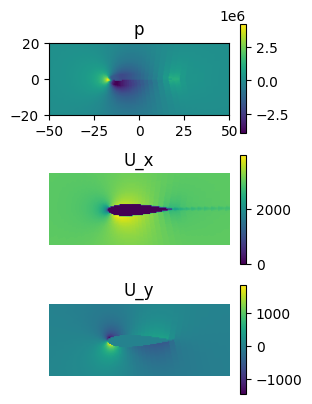

In [200]:
fig = plt.figure()
n=1200

fig.add_subplot(3, 2, 1)
plt.imshow(df_label[n,:,:,3],extent=[-50,50,-20,20])
plt.title('p')
plt.axis('on')
plt.colorbar()


fig.add_subplot(3, 2, 3)
plt.imshow(df_label[n,:,:,0],extent=[-50,50,-20,20])
plt.title('U_x')
plt.axis('off')
plt.colorbar()

fig.add_subplot(3, 2, 5)
plt.imshow(df_label[n,:,:,1],extent=[-50,50,-20,20])
plt.title('U_y')
plt.axis('off')

plt.colorbar()
plt.show()

In [189]:
df_label[n,:,:,3].shape

(66, 256)

In [438]:
#normalise U Vektors
U_max=np.max(abs(df[:,:,:,[0,1,2]]))
p_max=np.max(abs(df[:,:,:,[3]]))
nut_max=np.max(abs(df[:,:,:,[4]]))
nuTilda_max=np.max(abs(df[:,:,:,[5]]))

normal=np.array([U_max,U_max,U_max, p_max,nut_max,nuTilda_max]).reshape(1,1,1,6)
print(normal)
np.save('cfdnetplus_models/model1/normal',normal)


[[[[4.49073389e+03 4.49073389e+03 4.49073389e+03 4.06376920e+07
    1.24413147e+02 1.24413147e+02]]]]


In [198]:
df1=df*1/normal
df_label1=df_label/normal

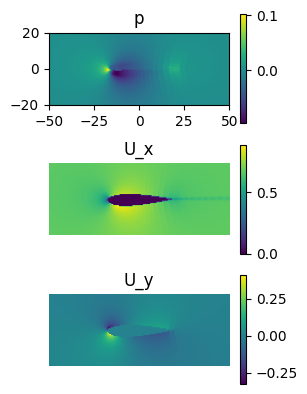

In [206]:
fig = plt.figure()

fig.add_subplot(3, 2, 1)
plt.imshow(df_label1[n,:,:,3],extent=[-50,50,-20,20])
plt.title('p')
plt.axis('on')
plt.colorbar()


fig.add_subplot(3, 2, 3)
plt.imshow(df_label1[n,:,:,0],extent=[-50,50,-20,20])
plt.title('U_x')
plt.axis('off')
plt.colorbar()

fig.add_subplot(3, 2, 5)
plt.imshow(df_label1[n,:,:,1],extent=[-50,50,-20,20])
plt.title('U_y')
plt.axis('off')

plt.colorbar()
plt.show()

In [207]:
train_data, test_data, label_train, label_test = train_test_split (df1, df_label1, test_size = 0.15)

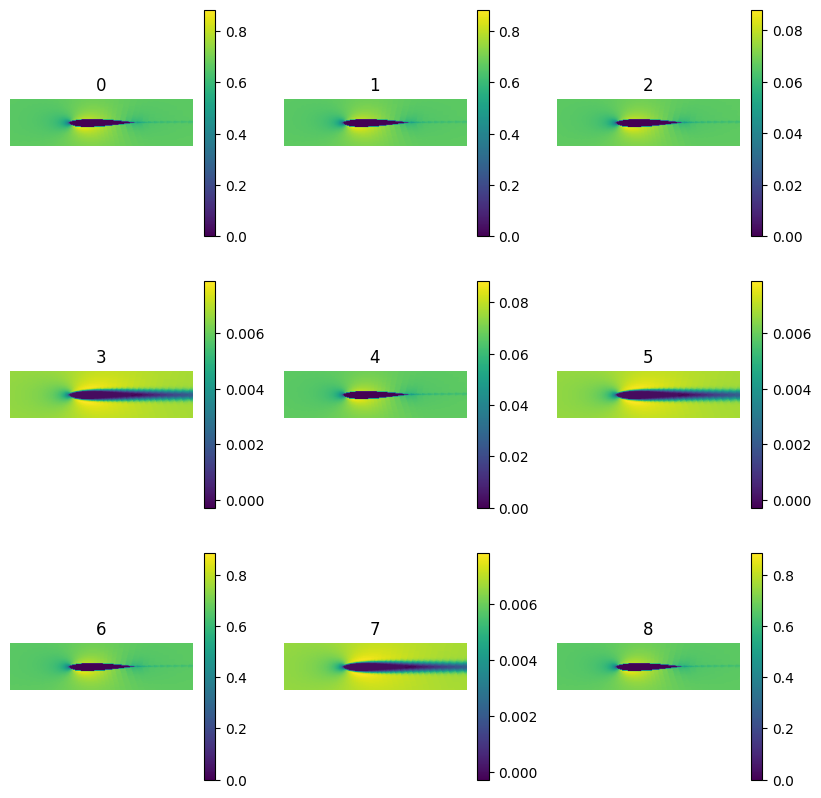

In [237]:
[a,b,c,d]=label_train.shape
fig = plt.figure(figsize=(10, 10))
columns = 3
rows = 3

for i in range( columns * rows):
    img = label_train[(i-1),:,:,0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.title(i)
    plt.axis('off')
    plt.colorbar()

plt.show()

In [408]:
# Valid for input with four layers
model = models.Sequential()
model.add(layers.Conv2D(16,(2, 8), (2, 8), activation='tanh', input_shape=(66,256, 6)))
model.add(layers.Conv2D(64,(3, 4), (3, 4), activation='tanh',))
model.add(layers.Conv2D(256,(11, 8), (11, 8), activation='tanh',))
model.add(layers.Conv2DTranspose(32,(14,10),(11,8), activation='tanh',padding="same"))
model.add(layers.Conv2DTranspose(16,(6,8),(3,4), activation='tanh',padding="same"))
model.add(layers.Conv2DTranspose(6,(4,16),(2,8), activation='linear', padding="same"))

In [409]:
model.summary()

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_182 (Conv2D)         (None, 33, 32, 16)        1552      
                                                                 
 conv2d_183 (Conv2D)         (None, 11, 8, 64)         12352     
                                                                 
 conv2d_184 (Conv2D)         (None, 1, 1, 256)         1442048   
                                                                 
 conv2d_transpose_180 (Conv2  (None, 11, 8, 32)        1146912   
 DTranspose)                                                     
                                                                 
 conv2d_transpose_181 (Conv2  (None, 33, 32, 16)       24592     
 DTranspose)                                                     
                                                                 
 conv2d_transpose_182 (Conv2  (None, 66, 256, 6)     

In [410]:
model.compile(optimizer='adam',
              loss='mse')

In [412]:
filefolder= 'training_5'
filepath = filefolder+'/'+'vae_best_model_relu.epoch{epoch:02d}-loss{loss:.5f}.w'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=1,
                             save_weights_only=True,
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [413]:
history = model.fit(train_data, label_train, epochs=100, 
                    validation_data=(test_data, label_test),
                    batch_size=32,
                   callbacks=callbacks)

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 0.0130
Epoch 1: loss improved from inf to 0.01298, saving model to training_5\vae_best_model_relu.epoch01-loss0.01298.w
33/33 [==============================] - 6s 158ms/step - loss: 0.0130 - val_loss: 0.0018
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 0.0012
Epoch 2: loss improved from 0.01298 to 0.00116, saving model to training_5\vae_best_model_relu.epoch02-loss0.00116.w
33/33 [==============================] - 5s 151ms/step - loss: 0.0012 - val_loss: 8.9417e-04
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 6.6738e-04
Epoch 3: loss improved from 0.00116 to 0.00067, saving model to training_5\vae_best_model_relu.epoch03-loss0.00067.w
33/33 [==============================] - 5s 150ms/step - loss: 6.6738e-04 - val_loss: 5.7154e-04
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 4.5535e-04
Epoch 4: loss improved from 0.00067 to 0.00046, saving model t

Epoch 29/100
33/33 [==============================] - ETA: 0s - loss: 3.5545e-05
Epoch 29: loss improved from 0.00004 to 0.00004, saving model to training_5\vae_best_model_relu.epoch29-loss0.00004.w
33/33 [==============================] - 5s 155ms/step - loss: 3.5545e-05 - val_loss: 3.5801e-05
Epoch 30/100
33/33 [==============================] - ETA: 0s - loss: 3.2292e-05
Epoch 30: loss improved from 0.00004 to 0.00003, saving model to training_5\vae_best_model_relu.epoch30-loss0.00003.w
33/33 [==============================] - 5s 158ms/step - loss: 3.2292e-05 - val_loss: 3.3478e-05
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 3.6250e-05
Epoch 31: loss did not improve from 0.00003
33/33 [==============================] - 5s 153ms/step - loss: 3.6250e-05 - val_loss: 4.2016e-05
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 3.6172e-05
Epoch 32: loss did not improve from 0.00003
33/33 [==============================] - 5s 151ms/step - loss

Epoch 59/100
33/33 [==============================] - ETA: 0s - loss: 1.2495e-05
Epoch 59: loss improved from 0.00001 to 0.00001, saving model to training_5\vae_best_model_relu.epoch59-loss0.00001.w
33/33 [==============================] - 5s 155ms/step - loss: 1.2495e-05 - val_loss: 1.3147e-05
Epoch 60/100
33/33 [==============================] - ETA: 0s - loss: 1.2248e-05
Epoch 60: loss improved from 0.00001 to 0.00001, saving model to training_5\vae_best_model_relu.epoch60-loss0.00001.w
33/33 [==============================] - 5s 157ms/step - loss: 1.2248e-05 - val_loss: 1.2904e-05
Epoch 61/100
33/33 [==============================] - ETA: 0s - loss: 1.1954e-05
Epoch 61: loss improved from 0.00001 to 0.00001, saving model to training_5\vae_best_model_relu.epoch61-loss0.00001.w
33/33 [==============================] - 5s 153ms/step - loss: 1.1954e-05 - val_loss: 1.2584e-05
Epoch 62/100
33/33 [==============================] - ETA: 0s - loss: 1.1647e-05
Epoch 62: loss improved from 0.

Epoch 89/100
33/33 [==============================] - ETA: 0s - loss: 7.1023e-06
Epoch 89: loss improved from 0.00001 to 0.00001, saving model to training_5\vae_best_model_relu.epoch89-loss0.00001.w
33/33 [==============================] - 5s 157ms/step - loss: 7.1023e-06 - val_loss: 7.2963e-06
Epoch 90/100
33/33 [==============================] - ETA: 0s - loss: 6.7991e-06
Epoch 90: loss improved from 0.00001 to 0.00001, saving model to training_5\vae_best_model_relu.epoch90-loss0.00001.w
33/33 [==============================] - 5s 155ms/step - loss: 6.7991e-06 - val_loss: 7.1738e-06
Epoch 91/100
33/33 [==============================] - ETA: 0s - loss: 7.0632e-06
Epoch 91: loss did not improve from 0.00001
33/33 [==============================] - 5s 155ms/step - loss: 7.0632e-06 - val_loss: 7.1766e-06
Epoch 92/100
33/33 [==============================] - ETA: 0s - loss: 7.4263e-06
Epoch 92: loss did not improve from 0.00001
33/33 [==============================] - 5s 150ms/step - loss

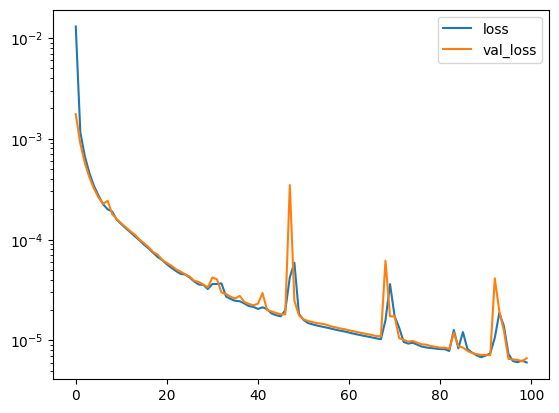

In [414]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
#plt.xlabel('Epoch')
#plt.ylabel('loss')
#plt.ylim([0.5, 1])
plt.yscale('log')
plt.legend(loc='upper right')

In [415]:
filefolder= 'training_5'
model.load_weights(filefolder+'/'+'vae_best_model_relu.epoch100-loss0.00001.w')

In [430]:
test=model.predict(test_data)

6/6 [==============================] - 0s 48ms/step


In [431]:
print(label_test.shape[0])
print('max:' , np.max(test))
print('min:' , np.min(test))
#label_test=label_test.reshape((36,66,256,4))
#plt.imshow(np.clip(label_test[1,:,:,3],0,1))

186
max: 0.90680796
min: -0.30291286


(186, 66, 256, 6)


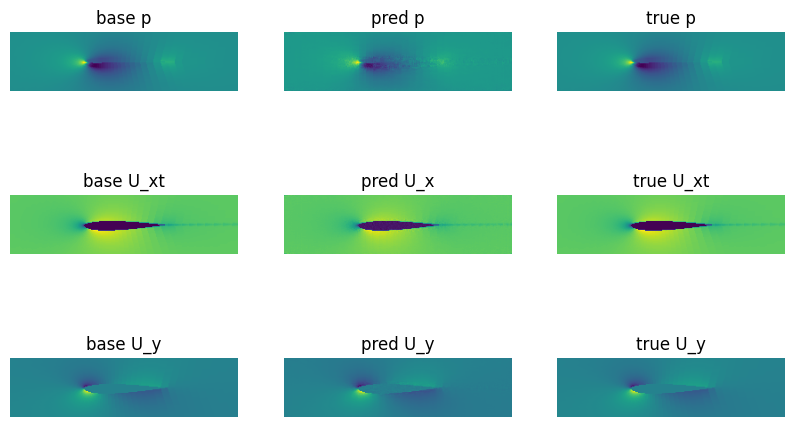

In [437]:
print(test_data.shape)
n=14
fig = plt.figure(figsize=(10, 6))

fig.add_subplot(3, 3, 2)
plt.imshow(test[n,:,:,3])
plt.title('pred p')
plt.axis('off')


fig.add_subplot(3, 3,5)
plt.imshow(test[n,:,:,0])
plt.title('pred U_x')
plt.axis('off')

fig.add_subplot(3, 3, 8)
plt.imshow(test[n,:,:,1])
plt.title('pred U_y')
plt.axis('off')

fig.add_subplot(3, 3, 1)
plt.imshow(test_data[n,:,:,3])
plt.title('base p')
plt.axis('off')


fig.add_subplot(3, 3,4)
plt.imshow(test_data[n,:,:,0])
plt.title('base U_xt')
plt.axis('off')

fig.add_subplot(3, 3, 7)
plt.imshow(test_data[n,:,:,1])
plt.title('base U_y')
plt.axis('off')

fig.add_subplot(3, 3, 3)
plt.imshow(label_test[n,:,:,3])
plt.title('true p')
plt.axis('off')


fig.add_subplot(3, 3,6)
plt.imshow(label_test[n,:,:,0])
plt.title('true U_xt')
plt.axis('off')

fig.add_subplot(3, 3, 9)
plt.imshow(label_test[n,:,:,1])
plt.title('true U_y')
plt.axis('off')


plt.show()

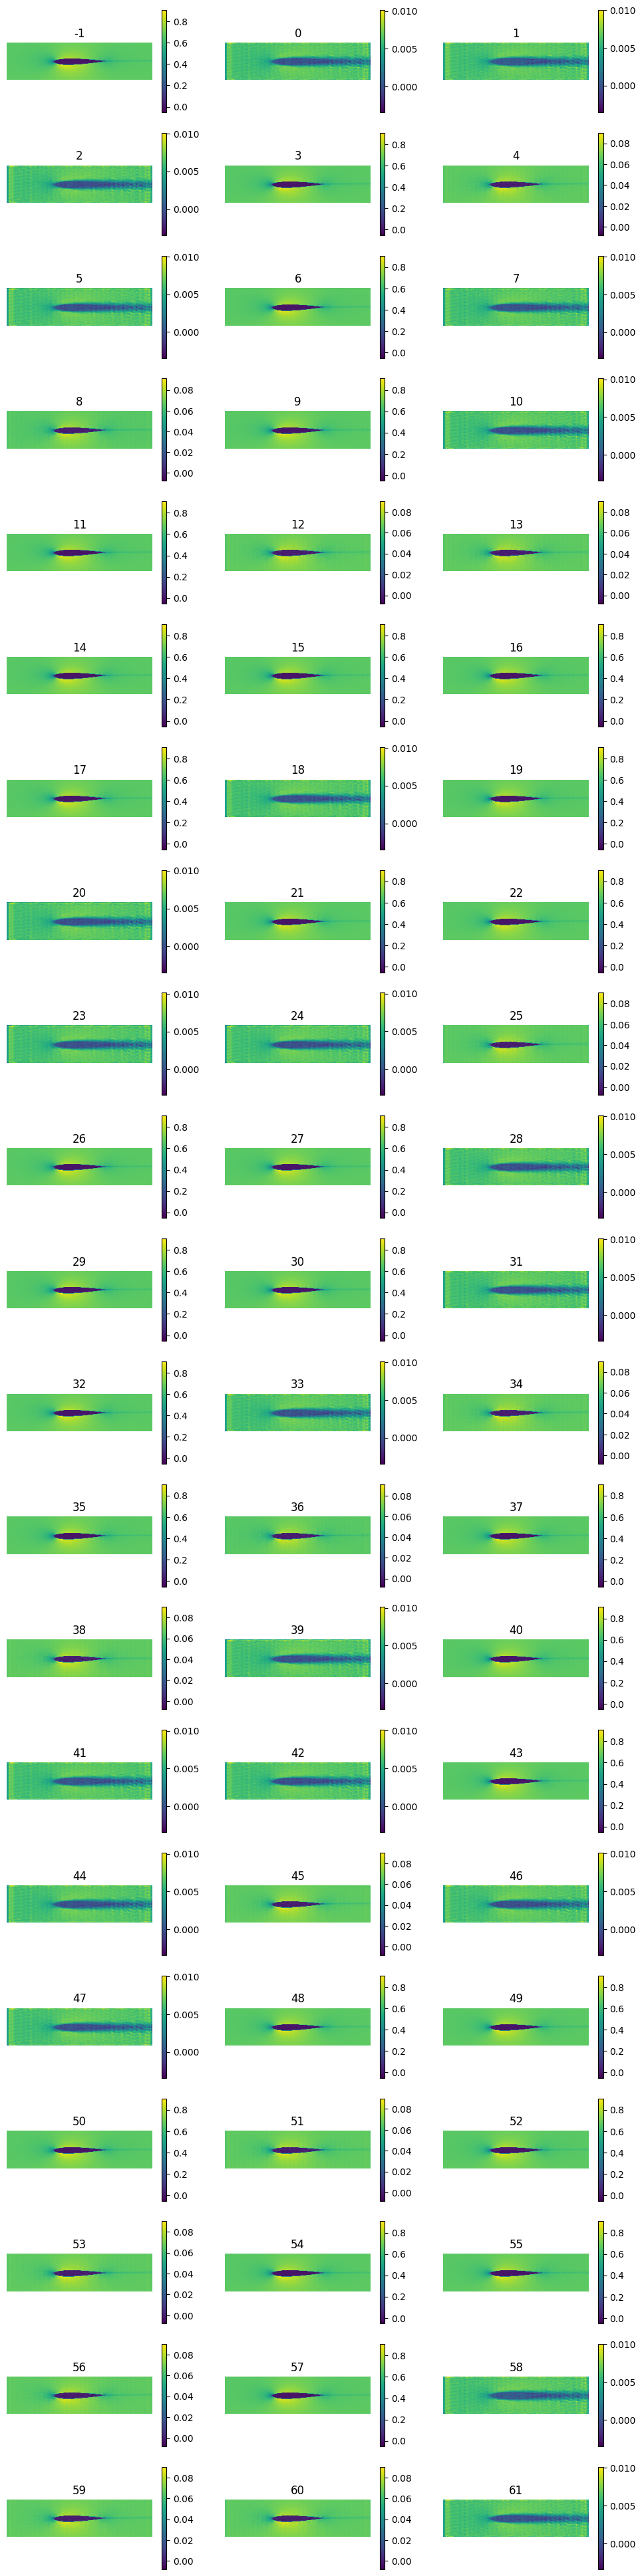

In [433]:
[a,b,c,d]=test.shape
fig = plt.figure(figsize=(12, 50))
columns = 3
rows = 21

for i in range( columns * rows):
    img = test[(i-1),:,:,0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.title(i-1)
    plt.axis('off')
    plt.colorbar()
plt.show()
    

In [434]:
mse=[]
ssim1=[]
for i in range(label_test.shape[0]):
    mse.append(mean_squared_error(test[i,:,:,3],label_test[i,:,:,3]))
    ssim1.append(ssim(test[i,:,:,3],label_test[i,:,:,3]))
print('max mse:'+ str(max(mse)))
print(ssim1[n])
print(mse[n])
mse=np.mean(mse)
ssim2=np.mean(ssim1[:])
print('average ssim: '+str(ssim2))
print('average mse: '+str(mse))

max mse:6.109830540452859e-06
0.9999631913860639
5.667613429814107e-08
average ssim: 0.9990216043296893
average mse: 2.694407239430557e-06


In [436]:
os.mkdir('cfdnetplus_models')
model.save('cfdnetplus_models/model1')

FileExistsError: [WinError 183] Eine Datei kann nicht erstellt werden, wenn sie bereits vorhanden ist: 'cfdnetplus_models'